This notebook is the tester for developing a system for recording models in a simplistic method

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import skew


import logging
log = logging.getLogger(__name__)

logging.basicConfig(filename='{}.log'.format('test'), level=logging.DEBUG)
log.info('Initiated Logging')



In [3]:
%load_ext autoreload
%autoreload 2


from lifecycle import lifecycle_model
from lifecycle import lifecycle_db


# local_db_cluster = 'cluster0.7ilyj.mongodb.net'
# local_username = 'projectUser'
# local_password = 'DCUpassword'
# localcloudclient = "mongodb+srv://{}:{}@{}/local_test".format(
#     local_username, local_password, local_db_cluster
#     )

my_life = lifecycle_model()
mydb = lifecycle_db (
#    localclient=localcloudclient,
    username = 'projectUser',password = 'DCUpassword',
    user='brendan.bonner2@mail.dcu.ie', organisation='Dublin City University',
    lifecycle=my_life)
mydb.init_model_db()


In [4]:
model_vgg16 = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

model_vgg16_test = model_vgg16

model_resnet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None
)

In [5]:


signature_vgg = mydb.push_model(model_vgg16,model_source="Keras Original VGG")
mydb.push_to_cloud(signature_vgg)
signature_resnet = mydb.push_model(model_resnet50,local=False, model_source="Keras Original ResNet50")


In [1]:
# Write function to get the memory utilisation of data model:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [16]:

import time

# Push all default models from Keras
keras_model_list = {
    'Original VGG16': tf.keras.applications.VGG16,
    'Original DenseNet121': tf.keras.applications.DenseNet121,
    'Original DenseNet169': tf.keras.applications.DenseNet169,
    'Original Xception': tf.keras.applications.Xception,
    'Xception': tf.keras.applications.Xception,
    'ResNet50': tf.keras.applications.ResNet50,
    'ResNet50V2': tf.keras.applications.ResNet50V2,
    'MobileNet': tf.keras.applications.MobileNet,
    'MobileNetV2': tf.keras.applications.MobileNetV2
}

for name, model_type in enumerate(keras_model_list):
    model = keras_model_list[model_type]()
    start = time.time()
    signature = mydb.push_model(model,model_source = model_type, organisation='Keras', local=False)
    lifecycle_model = mydb.get_model_data(signature=signature,local=False)
    end = time.time()

    lifecycle_size = get_size(lifecycle_model)
    print('{}\t{}\t{:.1f}kb\t{:.02f}s'.format(name, model_type, lifecycle_size/1000, end-start))




0	Original VGG16	38.2kb	4.07s
1	Original DenseNet121	693.8kb	0.38s
2	Original DenseNet169	952.1kb	0.91s
3	Original Xception	219.4kb	0.26s
4	Xception	219.4kb	0.26s
5	ResNet50	292.0kb	0.43s
6	ResNet50V2	311.3kb	0.43s
7	MobileNet	149.3kb	0.18s
8	MobileNetV2	248.5kb	0.20s


In [1]:
# Make a small adjustment to test the SHA change
model_vgg16_test = model_vgg16

first_time = True
for x in range(5):
    weights = model_vgg16_test.layers[1].get_weights()
    weights[0][0][0][0] = weights[0][0][0][0] * 1.004
    weights[0][0][0] = weights[0][0][0] * 1.025

    model_vgg16_test.layers[1].set_weights(weights)
    if first_time:
        last = mydb.push_model(model_vgg16_test, parent=signature_vgg)
    else:
        last = mydb.push_model(model_vgg16_test, useParent=True)
    first_time = False
    print(last)

mydb.family_tree(signature_vgg)

NameError: name 'model_vgg16' is not defined

In [6]:
# Push all default models from Keras
keras_model_list = {
    'VGG16': tf.keras.applications.VGG16,
    'DenseNet121': tf.keras.applications.DenseNet121,
    'Xception': tf.keras.applications.Xception,
    'ResNet50': tf.keras.applications.ResNet50,
    'ResNet50V2': tf.keras.applications.ResNet50V2,
    'MobileNet': tf.keras.applications.MobileNet,
    'MobileNetV2': tf.keras.applications.MobileNetV2
}

local=False

for name, model_type in enumerate(keras_model_list):
    print(model_type)
    model = keras_model_list[model_type]()
    print(mydb.push_model(model,model_source = model_type, organisation='Keras',local=local))



VGG16
ede69fca86a03c780a98dcec6fc1cfe406a3448dcba95663baa18bf853bc2f0f
DenseNet121
42f9a65180edde3acf9eb4a0ff56659d79e2f7093e62d5a2de315555307b5e96
Xception
bbd930cc56dfa39dc55e1318d9b5da2571d9eff0eeb96de7648faacb69c253cd
ResNet50
11038ddd9667dc41fdda32191266367a344ac28c0dde3bb3f5a86d8c7b67f0b0
ResNet50V2
10bf6fbdb86fca9e3e1bce872218c43a7017d4b13b397dfa1ab756eca3dc7d0b
MobileNet
39b71fdd645325e8eef30d20de0eae89016a1433fad4ce4e72bba89d42194c8e
MobileNetV2
67e68324dfc941f6318304b99e0afddd8d50fd1636204701949fa2777428f308


In [24]:
# Compare Updated Model
last = 'fdbd6c588bf88021f7762d428fbc2e4ab52887fc4634dc3f3c7345d67ad1ff69'
model_trail = mydb.get_history(last)
for x in model_trail:
    print_struct = False
    if x['structural_diff']:
        if x['structural_diff'] > 0: s = True

    if x['data_diff']:
        print_weight = (1 - x['data_diff']['weight']) * 100
        print_skew = (1 - x['data_diff']['skew']) * 100
    else:
        print_weight = 0
        print_skew = 0

    print('{} {}, Structure Change: {}, Weight Change {:.4f}% Skew Change {:.4f}%'. format(
        x['timestamp'],
        x['username'],
        print_struct,
        print_weight,
        print_skew))


2021-08-08 23:24:31+00:00 brendan.bonner2@mail.dcu.ie, Structure Change: False, Weight Change 0.3657% Skew Change -20.6553%
2021-08-08 23:24:28+00:00 brendan.bonner2@mail.dcu.ie, Structure Change: False, Weight Change 0.3496% Skew Change -16.1780%
2021-08-08 23:24:25+00:00 brendan.bonner2@mail.dcu.ie, Structure Change: False, Weight Change 0.3342% Skew Change -13.1552%
2021-08-08 23:24:21+00:00 brendan.bonner2@mail.dcu.ie, Structure Change: False, Weight Change 0.3194% Skew Change -10.9794%
2021-08-08 23:24:16+00:00 brendan.bonner2@mail.dcu.ie, Structure Change: False, Weight Change 0.5589% Skew Change -25.9141%
2021-08-08 23:04:38+00:00 brendan.bonner2@mail.dcu.ie, Structure Change: False, Weight Change 0.0000% Skew Change 0.0000%


In [7]:

ancestor = mydb.get_ancestor(last)

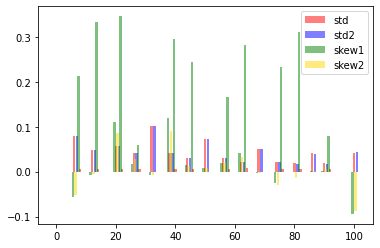

In [8]:
#Display a comparison of multiple layers

def hist_weights(sig1, sig2):

    hist_std1 = []
    hist_std2 = []
    hist_skew1 = []
    hist_skew2 = []

    hist_1 = mydb.get_model_data(signature=sig1)
    hist_2 = mydb.get_model_data(signature=sig2)

    for key, value in hist_1['data'].items():
        hist_std1.append(value['weight_std'])
        hist_skew1.append(value['skew'])

    for key, value in hist_2['data'].items():
        hist_std2.append(value['weight_std'])
        hist_skew2.append(value['skew'])

    layers = len(hist_1['data'])
    plt.bar( np.arange(layers) * 2, hist_std1, color = 'red' , alpha=0.5, label='std')
    plt.bar( np.arange(layers)* 2 + 1, hist_std2, color = 'blue', alpha=0.5, label='std2' )
    plt.legend(loc='upper right')
    plt.show

    plt.bar( np.arange(layers) * 2 -0.5, hist_skew1, color = 'green' , alpha=0.5, label='skew1')
    plt.bar( np.arange(layers)* 2 + 0.5, hist_skew2, color = 'gold', alpha=0.5, label='skew2' )
    plt.legend(loc='upper right')
    plt.show


#hist_weights(sig1, sig2)
hist_weights(last, ancestor)


In [9]:
hist_std = 1
hist_skew = 1
for i,v in enumerate(hist_std1):
    if (v != 0):
        hist_std = (hist_std2[i] / v) * hist_std
    if (hist_skew1[i] != 0):
        hist_skew = (hist_skew2[i] / hist_skew1[i]) * hist_skew

print ('std diff : {:.4f} %'.format((1-hist_std) * 100))
print ('skw diff : {:.4f} %'.format((1-hist_skew) * 100))

layers = len(hist_std1)


plt.bar( np.arange(layers) * 2, hist_std1, color = 'red' , alpha=0.5, label='std1')
plt.bar( np.arange(layers)* 2 + 1, hist_std2, color = 'blue', alpha=0.5, label='std2' )
plt.legend(loc='upper right')

plt.show



NameError: name 'hist_std1' is not defined

16


<function matplotlib.pyplot.show(close=None, block=None)>

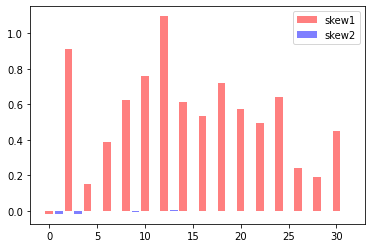

In [ ]:
layers = len(hist_skew1)
print(layers)
plt.bar( np.arange(layers) * 2, hist_skew1, color = 'red' , alpha=0.5, label='skew1')
plt.bar( np.arange(layers)* 2 + 1, hist_skew2, color = 'blue', alpha=0.5, label='skew2' )
plt.legend(loc='upper right')
plt.show

In [45]:

# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
# define the keras model

model1 = Sequential()
model1.add(Dense(12, input_dim=8, activation='relu'))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model2 = Sequential()
model2.add(Dense(12, input_dim=8, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model1.summary(), model2.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 104       
____________________________________

In [48]:

sig1 = mydb.push_model(model1)
sig2 = mydb.push_model(model2)

print(mydb.get_signature(sig1))
mydb.compare_models(sig1,sig2)

{'_id': ObjectId('610b31e1a985835c60aec9ab'), 'signature': 'ad0d96dbe354e2c07000ed44e7613fbd15acffda58a0e1ec350cf8a6dbd5bee3', 'parent': None, 'username': 'brendan.bonner2@mail.dcu.ie', 'organisation': 'Dublin City University', 'model_source': '', 'model_data': ObjectId('610b31e1a985835c60aec9aa')}


{'structure': {'dictionary_item_added': 1},
 'data': [0.9886274302058712, 1.1771883825934093, 1.5374055067233445]}

In [11]:
import hashlib
import time 
model = tf.keras.applications.VGG16()

start = time.time()
sha = hashlib.sha256()
sha.update(repr(model).encode('utf-8'))
end = time.time()
print('base model hash:', end-start)

start = time.time()
my_life.create_model_data(model)
end = time.time()
print('mydb model hash:', end-start)




base model hash: 0.0001442432403564453
mydb model hash: 4.187538146972656
